In [1]:
# Initialize Otter
import otter
grader = otter.Notebook("Traffic_part1.ipynb")

# Final Project: Traffic
## Due Date: Wednesday, November 17th, 11:59 PM
## Collaboration Policy

Data science is a collaborative activity. While you may talk with other groups about
the project, we ask that you **write your solutions within your own groups**. If you do
discuss the assignments with others outside of your group please **include their names** at the top
of your notebook.

# Data 100 Final Project: Traffic in a post-lockdown world

**Scenario:** You're a data scientist at Uber -- sitting in a war room on March 16, 2020, 1 day after California-wide COVID lockdown measures began and the day shelter-in-place measures are announced in the bay area. The entire data science department is on fire: All of your existing traffic models have regressed *significantly*. Given the sudden change in traffic patterns (i.e., no traffic at all), the company's traffic estimates are wildly incorrect. This is a top priority for the company. Since traffic estimates are used directly for pricing strategies, this is actively costing the company millions every hour. You are tasked with fixing these models.

**Takeaways:** How do you "fix" models that have learned biases from pre-lockdown traffic? How do you train new ones, with just 24 hours of data? What sorts of data do you examine, to better understand the situation? In the midst of company-wide panic, you'll need a strong inferential acumen to lead a robust data science response. In this project, we'll walk you through a simulated war room data science effort, culminating in some strategies to fix models online, which are experiencing large distributional shifts in data.

For this project, we'll explore traffic data provided by the **Uber Movement** dataset, specifically around the start of COVID shutdowns in March 2020. Your project is structured around the following ideas:

```
1. Guided data cleaning: Clustering data spatially
    a. Load Uber traffic speeds dataset
    b. Map traffic speeds to Google Plus Codes (spatially uniform)
        i. Load node-to-gps-coordinates data
        ii. Map traffic speed to GPS coordinates
        iii. Convert GPS coordinates to plus code regions
        iv. Sanity check number of plus code regions in San Francisco
        v. Plot a histogram of the standard deviation in speed, per plus code region.
    c. Map traffic speeds to census tracts (spatially non-uniform)
        i. Download census tracts geojson
        ii. Map traffic speed to census tracts
        iii. Sanity check number of census tracts in San Francisco with data.
        iv. Plot a histogram of the standard deviation in speed, per census tract.
    d. What defines a "good" or "bad" spatial clustering?
2. Guided EDA: Understanding COVID lockdown impact on traffic
    a. How did lockdown affect average traffic speeds?
        i. Sort census tracts by average speed, pre-lockdown.
        ii. Sort census tracts by average speed, post-lockdown.
        iii. Sort census tracts by change in average speed, from pre to post lockdown.
        iv. Quantify the impact of lockdown on average speeds.
        v. Quantify the impact of pre-lockdown average speed on change in speed.
    b. What traffic areas were impacted by lockdown?
        i. Visualize heatmap of average traffic speed per census tract, pre-lockdown.
        ii. Visualize change in average daily speeds pre vs. post lockdown.
        iii. Quantify the impact of lockdown on daily speeds, spatially.
3. Open-Ended EDA: Understanding lockdown impact on traffic times
    a. Download Uber Movement (Travel Times) dataset
4. Guided Modeling: Predict traffic speed post-lockdown
    a. Predict daily traffic speed on pre-lockdown data
        i. Assemble dataset to predict daily traffic speed.
        ii. Train and evaluate linear model on pre-lockdown data.
    b. Understand failures on post-lockdown data
        i. Evaluate on post-lockdown data
        ii. Report model performance temporally
    c. "Fix" model on post-lockdown data
        i. Learn delta off of a moving bias
        ii. Does it "solve itself"? Does the pre-lockdown model predict, after the change point?
        iii. Naively retrain model with post-lockdown data
        iv. What if you just ignore the change point?
5. Open-Ended Modeling: Predicting travel times post-lockdown
```

Concepts tested: regex, pivot, join, grouping, inferential thinking

In [2]:
import pandas as pd
import geopandas as gpd
import numpy as np
import csv
import json
import os
import contextily as cx
from collections import defaultdict
import re
from typing import Callable

from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt

from zipfile import ZipFile
zf = ZipFile('data.zip', 'r')
zf.extractall('.')

# Step 1 - Guided Data Cleaning: Partitioning Data Spatially

Our hope is answer: How do we group information spatially? We'll specifically look at 2 ways of partitioning data spatially, to understand the impact of spatial partitioning strategies on our analyses:

1. Dividing the world uniformly into slices, like Google's plus codes.
2. Dividing the world according to population, using census tracts.

In this step, we'll load the following datasets that we'll need for this project:

- Daily travel times from Uber Movement data in March 2020 from San Francisco, by census tract
- Daily traffic speeds from Uber Movement data in Q1 2020 from San Francisco, between OSM nodes
- Census tracts dividing San Francisco by GPS coordinates
- Mapping from OSM nodes to GPS coordinates

There are several terms and concepts to get familiar with upfront:

- **Open Street Maps (OSM)** provides nodes (points in space, [wiki](https://wiki.openstreetmap.org/wiki/Node)) and ways (segments between nodes [wiki](https://wiki.openstreetmap.org/wiki/Way)). These IDs are used in the Uber Movement dataset to identify streets in the traffic speeds dataset.
- **Census Tracts** provided by the county of San Francisco geographically divides space according to the US 2010 Census. This is used in the Uber Movement dataset to identify regions of differing travel times.

## 1.a. Load Uber traffic speeds dataset

The dataset is located at `data/movement-speeds-daily-san-francisco-2020-3.csv`. **Load this dataset into a dataframe.**

*The original dataset from Uber was provided hourly and took up 2.1 GB on disk, which means it couldn't fit into your 1GB of RAM. You can find the dataset preparation script at `data/PrepareTrafficDataset.ipynb` which aggregated within each day, reducing the dataset to just 55MB on disk.*

*This was originally going to be question in this project, but it takes 22 minutes to run. Better yet, if you mess up, your kernel dies and you start over. We deemed it too frustrating and preprocessed the dataset to spare you the pain... but just know that this is a real-world issue!*

<!--
BEGIN QUESTION
name: q1a
points: 1
-->

In [3]:
# Load Uber Movement (Movement Speeds) dataset into dataframe
speeds_to_nodes = pd.read_csv("data/movement-speeds-daily-san-francisco-2020-3.csv")

speeds_to_nodes

,osm_start_node_id,osm_end_node_id,day,speed_mph_mean
0,281266,702258940,1,59.674042
1,281266,702274215,1,68.444042
2,302876,240259516,1,66.446500
3,302878,437325360,1,65.516850
4,302883,65381191,1,61.880556
...,...,...,...,...
1586647,6569140748,1350115374,31,68.484833
1586648,6570476556,4551993266,31,36.837000
1586649,6573249373,4911384010,31,39.021000
1586650,6573553681,256888796,31,68.728333


In [4]:
grader.check("q1a")

q1a results: All test cases passed!

<!-- BEGIN QUESTION -->

## 1.b. Map traffic speed to Google Plus Codes

Google Plus Codes divide up the world uniformly into rectangular slices ([link](https://maps.google.com/pluscodes/)). Let's use this to segment traffic speeds spatially. Take a moment to answer: **Is this spatial structure effective for summarizing traffic speed?** Before completing this section, substantiate your answer with examples of your expectations (e.g., we expect A to be separated from B). After completing this section, substantiate your answer with observations you've made.

<!--
BEGIN QUESTION
name: q1b
points: 2
manual: True
-->

I expect this spatial structure to be effective for summarizing traffic speed because different areas or plus codes are more popular for people to visit than others. For instance, around more popular areas, such as Union Square, there will be more traffic because there is more demand for travelling to this area, while less popular areas, such as residetial areas, will have less traffic.

<!-- END QUESTION -->



### 1.b.i. Load Node-to-GPS-Coordinate Data

In this substep, we'll load a mapping from OSM nodes to GPS coordinates. The dataset is provided in a gzip'ed XML file from OpenStreetMaps (OSM). The mapping from OSM nodes to GPS coordinates was downloaded from https://download.bbbike.org/osm/bbbike/SanFrancisco/SanFrancisco.osm.gz. We've downloaded this for you, to avoid any issues with OSM updates.

**If** you try to load the provided `.osm` (an `.xml` in disguise) using Python's built-in XML utilities **(by uncommenting the last 2 lines in the below cell)**, you will hit an out-of-memory error, as your kernel is forced to restart.

In [5]:
# [OSM] - Read the OSM XML and extract mapping from node ID to GPS coordinates
PATH_OSM = os.path.expanduser('data/SanFrancisco.osm')

# Runs out of memory! File itself is 430 MB, even when filtering out
# irrelevant rows, and remaining 3M rows are too expensive to parse,
# resulting in OOM

# import xml.etree.ElementTree as ET
# _tree = ET.parse(PATH_OSM)

Your above code hits a memory error, so instead, we will use our handy-dandy tool--regex--from earlier in the semester to load just the parts of the file that we need. **Given the XML snippet below, write a regex pattern to extract OSM node ID, latitude, and longitude.** (The first capture group should be node ID. The second should be latitude, and the third should be longitude.) A snippet of the XML is included below ([screenshot](https://extract.bbbike.org/extract-screenshots.html)):

```
<?xml version='1.0' encoding='UTF-8'?>
<osm version="0.6" generator="osmconvert 0.8.3">
    <bounds minlat="42.4543" minlon="-2.4761999" maxlat="42.4..."/>
    <node id="26861066" lat="42.471111" lon="-2.454722" version="..."/>
        <tag k="name" v="Camping La Playa"/>
        <tag k="tourism" v="camp_site"/>
        <tag k="operator" v="private"/>
        ...
    </node>
    <node id="34793287" lat="42.4713587" lon="-2.4510783" version="..."/>
        <tag k="created_by" v="JOSM"/>
    </node>
    <node id="34793294" lat="42.4610836" lon="-2.4303622" version="..."/>
    <node id="34793297" lat="42.4548363" lon="-2.4287657" version="..."/>
    ...
</osm>
```

In [6]:
# [OSM] - Read the OSM XML using a regex operation instead.
def read_node_lat_lon(path: str, pattern: str, line_condition: Callable):
    """
    Read the provided path line at a line. If the provided regex pattern
    has a match, return the grouped matches as items in a generator.
    
    :param path: Path to read data from
    :param pattern: Regex pattern to test against each line
    :param line_condition: function that returns if we should check regex
        against current line
    """
    with open(path) as f:
        for line in f:
            result = re.search(pattern, line)
            if result is not None and line_condition(result):
                yield int(result.group(1)), float(result.group(2)), float(result.group(3))

In [7]:
node_ids = set(speeds_to_nodes.osm_start_node_id) | set(speeds_to_nodes.osm_end_node_id)

NODE_PATTERN = r"id=\"(\d+\.*\d*)\"\slat=\"(\d+\.*\d*)\"\slon=\"([-]*\d+\.*\d*)"

node_to_gps = pd.DataFrame(read_node_lat_lon(
    PATH_OSM,
    pattern=NODE_PATTERN,
    line_condition=lambda result: int(result.group(1)) in node_ids
), columns=['osm_node_id', 'Latitude', 'Longitude'])
node_to_gps

,osm_node_id,Latitude,Longitude
0,26118026,37.675280,-122.389194
1,29891973,37.674935,-122.389130
2,29892598,37.716892,-122.398893
3,30033679,37.599877,-122.376497
4,30033686,37.642167,-122.405946
...,...,...,...
19139,6522255428,37.760543,-122.443563
19140,6522255492,37.759317,-122.444996
19141,6522764204,37.762163,-122.436143
19142,6522764212,37.756061,-122.436761


In [8]:
grader.check("q1bi")

q1bi results: All test cases passed!

### 1.b.ii. Map traffic speed to GPS coordinates.

Traffic speeds are currently connected to OSM nodes. You will then use the mapping from OSM nodes to GPS coordinates, to map traffic speeds to GPS coordinates. **Link each traffic speed measurement to the GPS coordinate of its starting node.**

**Note**: For simplicity, assume each segment is associated with the node it *starts* with. 

**Hint**: Not all nodes are included in the OSM node mapping. Make sure to ignore any nodes without valid GPS coordinates.

<!--
BEGIN QUESTION
name: q1bii
points: 3
-->

In [9]:
# Find mapping from traffic speeds to GPS coordinates
speeds_to_gps = speeds_to_nodes.join(node_to_gps.set_index("osm_node_id"), on = "osm_start_node_id").dropna()
speeds_to_gps

,osm_start_node_id,osm_end_node_id,day,speed_mph_mean,Latitude,Longitude
141,26118026,259458979,1,64.478000,37.675280,-122.389194
233,29891973,434338966,1,67.489083,37.674935,-122.389130
234,29892598,1659365989,1,64.466458,37.716892,-122.398893
254,30033679,250031600,1,63.353364,37.599877,-122.376497
255,30033686,65370191,1,65.178000,37.642167,-122.405946
...,...,...,...,...,...,...
1586575,6502733624,260168596,31,33.423071,37.712530,-122.469258
1586597,6514737752,65328721,31,13.657500,37.797736,-122.407748
1586598,6522241813,6522255331,31,25.630000,37.757936,-122.443498
1586599,6522255331,6522255406,31,27.393000,37.757876,-122.443423


In [10]:
grader.check("q1bii")

q1bii results: All test cases passed!

### 1.b.iii. Convert GPS coordinates to plus code regions.

Plus code regions divide up the world into uniformly-sized rectangles, which we will assume is 0.012 degrees latitudiunally and longitudinally. **For each traffic speed row, compute the plus code region it belongs to**, based on its GPS coordinates.

To do this, we suggest computing a latitudinal index `plus_latitude_idx` and a longitudinal index `plus_longitude_idx` for the plus code region each row belongs to. *Make sure these columns are integer-valued*.

**Hint**: If you're running into nans, you did 1.b.ii. incorrectly!

<!--
BEGIN QUESTION
name: q1biii
points: 3
-->

In [11]:
speeds_to_gps['plus_latitude_idx'] = (speeds_to_gps['Latitude']/0.012).astype(int)
speeds_to_gps['plus_longitude_idx'] = (speeds_to_gps['Longitude']/0.012).astype(int)
speeds_to_gps

,osm_start_node_id,osm_end_node_id,day,speed_mph_mean,Latitude,Longitude,plus_latitude_idx,plus_longitude_idx
141,26118026,259458979,1,64.478000,37.675280,-122.389194,3139,-10199
233,29891973,434338966,1,67.489083,37.674935,-122.389130,3139,-10199
234,29892598,1659365989,1,64.466458,37.716892,-122.398893,3143,-10199
254,30033679,250031600,1,63.353364,37.599877,-122.376497,3133,-10198
255,30033686,65370191,1,65.178000,37.642167,-122.405946,3136,-10200
...,...,...,...,...,...,...,...,...
1586575,6502733624,260168596,31,33.423071,37.712530,-122.469258,3142,-10205
1586597,6514737752,65328721,31,13.657500,37.797736,-122.407748,3149,-10200
1586598,6522241813,6522255331,31,25.630000,37.757936,-122.443498,3146,-10203
1586599,6522255331,6522255406,31,27.393000,37.757876,-122.443423,3146,-10203


In [12]:
grader.check("q1biii")

q1biii results: All test cases passed!

### 1.b.iv. Sanity check number of plus code regions in San Francisco.

**Compute the number of unique plus codes found in your dataset**. You're checking that the number isn't ridiculous, like 1, or 100,000 (SF is 231 sq mi, so 100k tracts would average 12 sq ft per tract).

If you followed the suggestion above, this is the number of unique `(plus_latitude_idx, plus_longitude_idx)` pairs.

<!--
BEGIN QUESTION
name: q1biv
points: 4
-->

In [13]:
# You're expecting 276 plus codes here. Don't just type "276" 
# below to pass the autograder. The goal is to sanity check your 
# dataframe!
num_pluscode_regions = len(speeds_to_gps.groupby(["plus_latitude_idx", "plus_longitude_idx"]).size())
num_pluscode_regions

276

In [14]:
grader.check("q1biv")

q1biv results: All test cases passed!

<!-- BEGIN QUESTION -->

### 1.b.v. How well do plus code regions summarize movement speeds?

The following will give us an idea of how well the average represents traffic speed per plus code region. For these questions, we'll refer to a "plus code region" as a "cluster":

1. **Plot a histogram of the within-cluster standard deviation**.
2. **Compute across-cluster average of within-cluster standard deviation**.
3. **Compute across-cluster standard deviation of within-cluster average speeds**.
4. **Is this average variance reasonable?** To assess what "reasonable" means, consider these questions and how to answer them: (1) Do plus codes capture meaningful subpopulations? (2) Do differences between subpopulations outweigh differences within a subpopulation? Use the statistics above to answer these questions, and compute any additional statistics you need. Additionally explain *why these questions are important to assessing the quality of a spatial clustering*.

**Hint**: Run the autograder first to ensure your variance average and average variance are correct, before starting to draw conclusions.

In the first cell, write your written answers. In the second cell, complete the code.

<!--
BEGIN QUESTION
name: q1bv1
points: 2
manual: True
-->



I think the average variance is reasonable. Based on our data, across-cluster standard deviation of within cluster average speeds was greater than the across cluster average of within cluster standard deviation, which tells us that clusters differ more with each other compared to the population within itself. Yes, differences between subpopulations do outweigh differences within a subpopulation, and this can be attributed to the demographics of the people and driving speeds within a cluster. This information may tell us that it would be more effective to utilize spatial clustering by plus codes since our data seems to suggest there is less variation within a cluster than between clusters.

<!-- END QUESTION -->

<!-- BEGIN QUESTION -->

<!--
BEGIN QUESTION
name: q1bv2
points: 2
manual: True
-->

(8.684748294968637, 10.13573858675904)

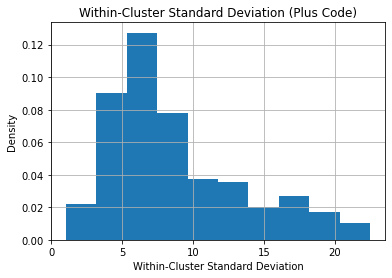

In [15]:
speed_variance_by_pluscode = speeds_to_gps.groupby(["plus_latitude_idx", "plus_longitude_idx"]).aggregate(np.std).reset_index()["speed_mph_mean"]# compute traffic speed variance in each plus code region
speed_variance_by_pluscode.hist(density = True)
plt.title("Within-Cluster Standard Deviation (Plus Code)")
plt.xlabel("Within-Cluster Standard Deviation")
plt.ylabel("Density")# plot a histogram
average_variance_by_pluscode = np.mean(speed_variance_by_pluscode)
variance_average_by_pluscode = speeds_to_gps.groupby(["plus_latitude_idx", "plus_longitude_idx"]).aggregate(np.mean).reset_index()["speed_mph_mean"].std()
average_variance_by_pluscode, variance_average_by_pluscode

<!-- END QUESTION -->

<!--
BEGIN QUESTION
name: q1bv3
points: 3
-->

In [16]:
speed_variance_by_pluscode

0       3.650232
1      20.704487
2      12.342234
3       4.083821
4      21.390912
         ...    
271    15.293632
272    17.915911
273    14.243592
274    12.237229
275    17.590817
Name: speed_mph_mean, Length: 276, dtype: float64

In [17]:
grader.check("q1bv3")

q1bv3 results: All test cases passed!

## 1.c. Map traffic speed to census tract.

Census tracts divide the space much less uniformly, subdividing regions that we were interested in into smaller zones. This suggests promise in providing informative spatial segments. Note that the daily traffic speeds are provided between OpenStreetMap (OSM) nodes, so we'll need to map nodes to census tracts somehow.

Above, we've mapped traffic speeds to GPS coordinates. Below, we'll then link GPS coordinates to census tracts, to complete the mapping from traffic speeds to census tracts.

### 1.c.i. Download Census Tracts Geojson

**Load the census tracts geojson.** Make sure to see the relevant [geopandas io documentation](https://geopandas.org/docs/user_guide/io.html) to see how to load a geojson.

**Hint**: It should take you just one line to load.

<!--
BEGIN QUESTION
name: q1ci
points: 1
-->

In [18]:
PATH_TRACTS = os.path.expanduser('data/san_francisco_censustracts.json')
tract_to_gps = gpd.read_file(PATH_TRACTS)
tract_to_gps['MOVEMENT_ID'] = tract_to_gps['MOVEMENT_ID'].astype(int)
tract_to_gps

,MOVEMENT_ID,DISPLAY_NAME,geometry
0,1,"Sargent Creek, San Ardo","MULTIPOLYGON (((-121.59511 36.11126, -121.5401..."
1,2,"400 Northumberland Avenue, Redwood Oaks, Redwo...","MULTIPOLYGON (((-122.22463 37.46507, -122.2236..."
2,3,"18300 Sutter Boulevard, Morgan Hill","MULTIPOLYGON (((-121.67978 37.15859, -121.6719..."
3,4,"2700 Stoughton Way, Sheffield, Sacramento","MULTIPOLYGON (((-121.35921 38.57175, -121.3462..."
4,5,"3200 Huntsman Drive, Rosemont Park, Sacramento","MULTIPOLYGON (((-121.37512 38.55309, -121.3715..."
...,...,...,...
2705,2706,"10000 Bobbell Drive, Elk Grove","MULTIPOLYGON (((-121.48392 38.40874, -121.4787..."
2706,2707,"400 Ericwood Court, Manteca","MULTIPOLYGON (((-121.22695 37.82647, -121.2185..."
2707,2708,"200 Westview Drive, Sunshine Gardens, South Sa...","MULTIPOLYGON (((-122.45179 37.66912, -122.4506..."
2708,2709,"1200 Halyard Drive, West Sacramento","MULTIPOLYGON (((-121.58346 38.57860, -121.5827..."


In [19]:
grader.check("q1ci")

q1ci results: All test cases passed!

### 1.c.ii Map traffic speed to census tracts.

You will need to *spatially join* the (1) mapping from traffic speed to GPS coordinates `speed_to_gps` and (2) the mapping from GPS coordinates to boundaries of census tracts `tract_to_gps` to group all traffic speeds by census tract. This "spatial join" is an advanced feature recently released (as of time of writing, in Oct 2021) in geopandas, which allows us to connect single points to their enclosing polygons. You will do this question in 3 parts:

1. Convert the last dataframe `speeds_to_gps` into a geopandas dataframe `speeds_to_points`, where GPS coordinates are now geopandas points. See this tutorial: https://geopandas.org/gallery/create_geopandas_from_pandas.html#From-longitudes-and-latitudes
2. Set the coordinate-system for the new geopandas dataframe to the "world geodesic system" [link](https://epsg.io/4326), or in other words, the coordinate system that GPS coordinates are reported in.
3. Compute a spatial join between census tracts `tract_to_gps` and the geopandas traffic speeds `speeds_to_points`

<!--
BEGIN QUESTION
name: q1cii
points: 4
-->

In [20]:
speeds_to_points = gpd.GeoDataFrame(speeds_to_gps, geometry=gpd.points_from_xy(speeds_to_gps.Longitude, speeds_to_gps.Latitude)).set_crs(epsg = 4326)
speeds_to_tract = tract_to_gps.sjoin(speeds_to_points)

speeds_to_tract

,MOVEMENT_ID,DISPLAY_NAME,geometry,index_right,osm_start_node_id,osm_end_node_id,day,speed_mph_mean,Latitude,Longitude,plus_latitude_idx,plus_longitude_idx
8,9,"500 Hyde Street, Tenderloin, San Francisco","MULTIPOLYGON (((-122.41827 37.78704, -122.4150...",1373312,5429620647,65333834,16,4.390000,37.784356,-122.416866,3148,-10201
8,9,"500 Hyde Street, Tenderloin, San Francisco","MULTIPOLYGON (((-122.41827 37.78704, -122.4150...",1585441,5429620647,65333834,31,20.707000,37.784356,-122.416866,3148,-10201
8,9,"500 Hyde Street, Tenderloin, San Francisco","MULTIPOLYGON (((-122.41827 37.78704, -122.4150...",1553990,5429620647,65333834,28,22.594000,37.784356,-122.416866,3148,-10201
8,9,"500 Hyde Street, Tenderloin, San Francisco","MULTIPOLYGON (((-122.41827 37.78704, -122.4150...",953658,5429620647,65333834,10,8.893125,37.784356,-122.416866,3148,-10201
8,9,"500 Hyde Street, Tenderloin, San Francisco","MULTIPOLYGON (((-122.41827 37.78704, -122.4150...",1397113,5429620647,65333834,17,5.634000,37.784356,-122.416866,3148,-10201
...,...,...,...,...,...,...,...,...,...,...,...,...
2707,2708,"200 Westview Drive, Sunshine Gardens, South Sa...","MULTIPOLYGON (((-122.45179 37.66912, -122.4506...",420477,65436480,4552055202,5,22.683500,37.661119,-122.438615,3138,-10203
2707,2708,"200 Westview Drive, Sunshine Gardens, South Sa...","MULTIPOLYGON (((-122.45179 37.66912, -122.4506...",899242,65436480,4550820797,10,24.717000,37.661119,-122.438615,3138,-10203
2707,2708,"200 Westview Drive, Sunshine Gardens, South Sa...","MULTIPOLYGON (((-122.45179 37.66912, -122.4506...",218764,267053289,5435703115,3,21.337000,37.663610,-122.441970,3138,-10203
2707,2708,"200 Westview Drive, Sunshine Gardens, South Sa...","MULTIPOLYGON (((-122.45179 37.66912, -122.4506...",241505,2278938365,267053289,3,12.112500,37.664004,-122.442453,3138,-10203


In [21]:
grader.check("q1cii")

q1cii results: All test cases passed!

### 1.c.iii. Aggregate movement speeds by census tract.

- Create a new dataframe `speeds_by_tract` to group movement speeds by census tract. See the outputted dataframe from 1.c.i. to check how census tracts are identified.
- Always double-check your numbers. **Report the number of census tracts** in your dataset.

<!--
BEGIN QUESTION
name: q1ciii
points: 2
-->

In [22]:
speeds_by_tract = speeds_to_tract.groupby("MOVEMENT_ID")
num_census_tracts = len(speeds_by_tract.size())
num_census_tracts

295

In [23]:
grader.check("q1ciii")

q1ciii results: All test cases passed!

<!-- BEGIN QUESTION -->

### 1.c.iv. How well do census tracts summarize movement speeds?

The following will give us an idea of how well the average represents traffic speed per plus code region. For these questions, we'll refer to a "census tract" as a "cluster":

1. **Plot a histogram of the within-cluster standard deviation**.
2. **Compute across-cluster average of within-cluster standard deviation**.
3. **Compute across-cluster standard deviation of within-cluster average speeds**.
4. **Is this average variance reasonable?** To assess what "reasonable" means, consider these questions and how to answer them: (1) Do plus codes capture meaningful subpopulations? (2) Do differences between subpopulations outweigh differences within a subpopulation? Use these ideas to assess whether the average standard deviation is high or not.

Note: We are using the speed metric of miles per hour here.

Just like before, please written answers in the first cell and coding answers in the second cell.
<!--5. Using the above, how would you **compare census tracts to plus codes, in terms of its effectiveness** as a spatial clustering mechanism for analyzing traffic speeds? Compare the statistics you've computed. What does it mean for one to be higher than the other?-->

<!--
BEGIN QUESTION
name: q1civ1
points: 2
manual: True
-->



Unlike by plus codes, the variance this time seems to be more similar within and across clusters. Therefore, it seems like census tracts don't capture meaningful subpopulations and the differences between subpopuations are similar to the differences within the subpopulation. The average standard deviation seems to be normal. Thus, the average variance is not reasonable because it doesn't capture meaningful subpopulations.

<!-- END QUESTION -->

<!-- BEGIN QUESTION -->

<!--
BEGIN QUESTION
name: q1civ2
points: 2
manual: True
-->

(8.300873802949296, 8.346122597861662)

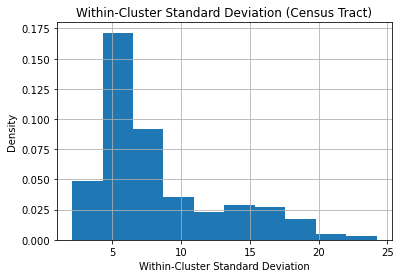

In [24]:
speed_variance_by_tract = speeds_by_tract.aggregate(np.std)["speed_mph_mean"]
speed_variance_by_tract.hist(density = True)
plt.title("Within-Cluster Standard Deviation (Census Tract)")
plt.xlabel("Within-Cluster Standard Deviation")
plt.ylabel("Density")# plot a histogram
average_variance_by_tract = np.mean(speed_variance_by_tract)
variance_average_by_tract = speeds_by_tract.mean()["speed_mph_mean"].std()
average_variance_by_tract, variance_average_by_tract

<!-- END QUESTION -->

<!--
BEGIN QUESTION
name: q1civ3
points: 3
-->

In [25]:
speed_variance_by_tract

MOVEMENT_ID
9        3.821144
20       5.522853
21       3.640453
44       6.634154
78       3.838873
          ...    
2691     3.379664
2694     5.787065
2695     4.617596
2700    13.191079
2708     7.136608
Name: speed_mph_mean, Length: 295, dtype: float64

In [26]:
grader.check("q1civ3")

q1civ3 results: All test cases passed!

<!-- BEGIN QUESTION -->

## 1.d. What would be the ideal spatial clustering?

This is an active research problem in many spatiotemporal modeling communities, and there is no single agreed-upon answer. Answer both of the following specifically knowing that you'll need to analyze traffic patterns according to this spatial clustering:

1. **What is a good metric for a spatial structure?** How do we define good? Bad? What information do we expect a spatial structure to yield? Use the above parts and questions to help answer this.
2. **What would you do to optimize your own metric for success in a spatial structure?**

See related articles:

- Uber's H3 [link](https://eng.uber.com/h3/), which divides the world into hexagons
- Traffic Analysis Zones (TAZ) [link](https://en.wikipedia.org/wiki/Traffic_analysis_zone), which takes census data and additionally accounts for vehicles per household when dividing space

<!--
BEGIN QUESTION
name: q1d
points: 3
manual: True
-->

A good metric for a spatial structure includes low variability within the cluster compared to the population. Each cluster would have to capture a unique population that would differentiate itself from the population, allowing us to make generalizations and draw conclusions upon the certain cluster. A good metric would also capture this information in a relatively simple manner, such as the hexagons that Uber's H3 uses. In order to optimize my own metric for success in a spatial structure, I would want to create such a clustering that minimizes within cluster variance in relation to across cluster variance. In doing so, the clusters that I define would have some meaningful difference that can correlate to the behavior I am observing. Further, this meaningful difference can then be used to extrapolate behavior through creating a model.

<!-- END QUESTION -->



# Step 2 - Guided EDA: Understanding COVID Lockdown Impact on Traffic

In this step, we'll examine the impact of COVID on traffic. In particular, we'll study 3 different questions:

- How did lockdown affect traffic speed? What factors dictate how much lockdown affected traffic speed?
- What areas of traffic were most impacted by lockdown?

## 2.a. How did lockdown affect traffic speed?

<!-- BEGIN QUESTION -->

### 2.a.i. Sort census tracts by average speed, pre-lockdown.

Consider the pre-lockdown period to be March 1 - 13, before the first COVID-related restrictions (travel bans) were announced on March 14, 2020.

1. **Report a DataFrame which includes the *names* of the 10 census tracts with the lowest average speed**, along with the average speed for each tract.
2. **Report a DataFrame which includes the *names* of the 10 census tracts with the highest average speed**, along with the average speed for each tract.
2. Do these names match your expectations for low speed or high speed traffic pre-lockdown?  What relationships do you notice? (What do the low-speed areas have in common? The high-speed areas?) For this specific question, answer qualitatively. No need to quantify. **Hint**: Look up some of the names on a map, to understand where they are.
3. **Plot a histogram for all average speeds, pre-lockdown**.
4. You will notice a long tail distribution of high speed traffic. What do you think this corresponds to in San Francisco? Write down your hypothesis.

Hint: To start off, think about what joins may be useful to get the desired DataFrame.

<!--
BEGIN QUESTION
name: q2ai1
points: 3
manual: True
-->

These names do match my expectations for low speed or high speed traffic pre-lockdown, as I notice that all of the locations in the 10 lowest average speed areas are in San Francisco. This is to be expected, as San Francisco is a metropolis, which comes with traffic as people move in and out of the city daily for work and play. Further, the locations are clustered around Union Square, which is a tourist attraction and has other attractions, such as shopping malls. For highest average speed areas, the locations are more spread out and are located in smaller cities surrounding San Francisco. They are also typically near nature, such as the ocean or in parks, where less people usually travel. I think the long tail distribution of high speed traffic corresponds to Highways in San Francisco, as there are relatively few of them with higher speed limits.

<!-- END QUESTION -->

Answer the following question:
<!--
BEGIN QUESTION
name: q2ai2
points: 3
-->

In [27]:
# compute the average speed per census tract (will use this later),
# BEFORE the shelter-in-place was announced on March 14, 2020.
# Autograder expects this to be a series
averages_pre = speeds_to_tract[speeds_to_tract["day"] < 14].groupby("MOVEMENT_ID").mean()["speed_mph_mean"]
# Autograder expects this to be a dataframe with name of census tract,
# polygon for census tract, and average speed per census tract
averages_pre_named = speeds_to_tract[speeds_to_tract["day"] < 14].groupby("MOVEMENT_ID").first()[["DISPLAY_NAME", "geometry"]]
averages_pre_named["speed_mph_mean"] = averages_pre
averages_pre_named

,DISPLAY_NAME,geometry,speed_mph_mean
MOVEMENT_ID,,,
9,"500 Hyde Street, Tenderloin, San Francisco","MULTIPOLYGON (((-122.41827 37.78704, -122.4150...",14.585102
20,"900 Sutter Street, Lower Nob Hill, San Francisco","MULTIPOLYGON (((-122.42208 37.78847, -122.4153...",15.679922
21,"3400 Pierce Street, Marina District, San Franc...","MULTIPOLYGON (((-122.44191 37.80374, -122.4371...",14.292445
44,"1700 Egbert Avenue, Bayview, San Francisco","MULTIPOLYGON (((-122.40211 37.72779, -122.3998...",23.353083
78,"1400 Thomas Avenue, Bayview, San Francisco","MULTIPOLYGON (((-122.39270 37.72928, -122.3918...",16.213552
...,...,...,...
2691,"800 Hacienda Way, Millbrae","MULTIPOLYGON (((-122.42288 37.60714, -122.4187...",20.746333
2694,"1900 Buchanan Street, Western Addition, San Fr...","MULTIPOLYGON (((-122.43549 37.78870, -122.4338...",17.042386
2695,"2200 Rivera Street, Sunset District, San Franc...","MULTIPOLYGON (((-122.49505 37.74968, -122.4858...",20.029011


In [28]:
grader.check("q2ai2")

q2ai2 results: All test cases passed!

Report the lowest 10 census tracts with the lowest average speed
Remember we want the NAME of each census tract too. For the autograder, please keep the name of the speed field, `speed_mph_mean`.

<!--
BEGIN QUESTION
name: q2ai3
points: 1
-->

In [29]:
bottom10_averages_pre = averages_pre_named.sort_values("speed_mph_mean").head(10)
bottom10_averages_pre

,DISPLAY_NAME,geometry,speed_mph_mean
MOVEMENT_ID,,,
1691,"200 O'Farrell Street, Tenderloin, San Francisco","MULTIPOLYGON (((-122.41462 37.78558, -122.4129...",12.417079
2340,"0 Mason Street, Tenderloin, San Francisco","MULTIPOLYGON (((-122.41405 37.78279, -122.4107...",12.595120
1688,"1100 Taylor Street, Nob Hill, San Francisco","MULTIPOLYGON (((-122.41629 37.79389, -122.4152...",12.945291
651,"2900 22nd Street, Mission District, San Francisco","MULTIPOLYGON (((-122.41672 37.75717, -122.4123...",13.195865
643,"200 Myrtle Street, Tenderloin, San Francisco","MULTIPOLYGON (((-122.42146 37.78663, -122.4182...",13.490311
1689,"200 Sutter Street, Financial District, San Fra...","MULTIPOLYGON (((-122.40879 37.79016, -122.4071...",13.502505
1244,"800 Jackson Street, Chinatown, San Francisco","MULTIPOLYGON (((-122.41172 37.79629, -122.4084...",13.549474
1245,"500 Geary Street, Tenderloin, San Francisco","MULTIPOLYGON (((-122.41500 37.78745, -122.4133...",13.570625
644,"200 Jones Street, Tenderloin, San Francisco","MULTIPOLYGON (((-122.41443 37.78466, -122.4127...",13.626251


In [30]:
grader.check("q2ai3")

q2ai3 results: All test cases passed!

Report the highest 10 census tracts with the highest average speed.

<!--
BEGIN QUESTION
name: q2ai4
points: 1
-->

In [31]:
top10_averages_pre = averages_pre_named.sort_values("speed_mph_mean", ascending = False).head(10)
top10_averages_pre

,DISPLAY_NAME,geometry,speed_mph_mean
MOVEMENT_ID,,,
285,"1600 Maritime Street, Oakland","MULTIPOLYGON (((-122.33037 37.82058, -122.3161...",59.498552
495,"4200 Shelter Creek Lane, San Bruno","MULTIPOLYGON (((-122.43101 37.61999, -122.4300...",53.867847
1653,"Petrolite Street, Richmond","MULTIPOLYGON (((-122.42976 37.96540, -122.4185...",47.318340
2339,"Frenchmans Creek Road, Half Moon Bay","MULTIPOLYGON (((-122.46816 37.56079, -122.4605...",47.225137
1744,"1200 Helen Drive, Millbrae","MULTIPOLYGON (((-122.42820 37.60497, -122.4263...",45.492292
2244,"0 Crystal Springs Terrace, Hillsborough Park, ...","MULTIPOLYGON (((-122.37189 37.54776, -122.3710...",44.304919
2660,"0 Burgess Court, Sausalito","MULTIPOLYGON (((-122.52032 37.87046, -122.5193...",43.848188
1955,"Liccicitos Road, Moss Beach","MULTIPOLYGON (((-122.52036 37.57534, -122.5180...",42.784267
1732,"0 Longview Drive, Westlake, Daly City","MULTIPOLYGON (((-122.50053 37.70083, -122.4961...",40.587037


In [32]:
grader.check("q2ai4")

q2ai4 results: All test cases passed!

<!-- BEGIN QUESTION -->

Plot the histogram
<!--
BEGIN QUESTION
name: q2ai5
points: 1
manual: True
-->

Text(0, 0.5, 'Density')

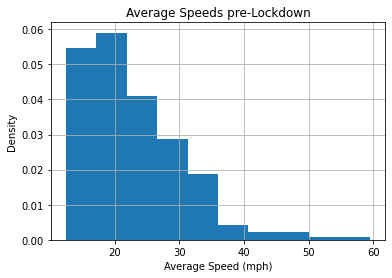

In [33]:
averages_pre.hist(density = True)
plt.title("Average Speeds pre-Lockdown")
plt.xlabel("Average Speed (mph)")
plt.ylabel("Density")

<!-- END QUESTION -->

<!-- BEGIN QUESTION -->

### 2.a.ii. Sort census tracts by average speed, post-lockdown.

I suggest checking the top 10 and bottom 10 tracts by average speed, post-lockdown. Consider the post-lockdown period to be March 14 - 31, after the first COVID restrictions were established on March 14, 2020. It's a healthy sanity check. For this question, you should report:

- **Plot a histogram for all average speeds, post-lockdown.**
- **What are the major differences between this post-lockdown histogram relative to the pre-lockdown histogram above**? Anything surprising? What did you expect, and what did you find?

Write the written answers in the cell below, and the coding answers in the cells after that.

<!--
BEGIN QUESTION
name: q2aii1
points: 1
manual: True
-->

It looks like average speeds have generally increased between this post-lockdown histogram relative to the pre-lockdown histogram. It looks as if the mode of the post-lockdown is 20-30 mph while the pre-lockdown mode was under 20. Further, there is overall more people driving faster, as there is density in the 60-70 range now whereas the pre-lockdown was capped at 60 mph. This increase of speed makes sense, as less cars on the roads due to lockdown decreases traffic dramatically. Thus, people who are on the streets are able to drive faster.

<!-- END QUESTION -->

<!--
BEGIN QUESTION
name: q2aii2
points: 2
-->

In [34]:
# compute the average speed per census tract (will use this later),
# AFTER (and including) the first COVID restrictions were put into effect.
# Autograder expects this to be a series
averages_post = speeds_to_tract[speeds_to_tract["day"] > 13].groupby("MOVEMENT_ID").mean()["speed_mph_mean"]
# Autograder expects this to be a dataframe with name of census tract,
# polygon for census tract, and average speed per census tract
averages_post_named = speeds_to_tract[speeds_to_tract["day"] > 13].groupby("MOVEMENT_ID").first()[["DISPLAY_NAME", "geometry"]]
averages_post_named["speed_mph_mean"] = averages_post
averages_post_named

,DISPLAY_NAME,geometry,speed_mph_mean
MOVEMENT_ID,,,
9,"500 Hyde Street, Tenderloin, San Francisco","MULTIPOLYGON (((-122.41827 37.78704, -122.4150...",16.143154
20,"900 Sutter Street, Lower Nob Hill, San Francisco","MULTIPOLYGON (((-122.42208 37.78847, -122.4153...",16.871488
21,"3400 Pierce Street, Marina District, San Franc...","MULTIPOLYGON (((-122.44191 37.80374, -122.4371...",15.754795
44,"1700 Egbert Avenue, Bayview, San Francisco","MULTIPOLYGON (((-122.40211 37.72779, -122.3998...",25.956602
78,"1400 Thomas Avenue, Bayview, San Francisco","MULTIPOLYGON (((-122.39270 37.72928, -122.3918...",16.476000
...,...,...,...
2691,"800 Hacienda Way, Millbrae","MULTIPOLYGON (((-122.42288 37.60714, -122.4187...",17.917000
2694,"1900 Buchanan Street, Western Addition, San Fr...","MULTIPOLYGON (((-122.43549 37.78870, -122.4338...",22.128519
2695,"2200 Rivera Street, Sunset District, San Franc...","MULTIPOLYGON (((-122.49505 37.74968, -122.4858...",23.440404


In [35]:
grader.check("q2aii2")

q2aii2 results: All test cases passed!

<!-- BEGIN QUESTION -->

Plot the histogram
<!--
BEGIN QUESTION
name: q2aii3
points: 1
manual: True
-->

Text(0, 0.5, 'Density')

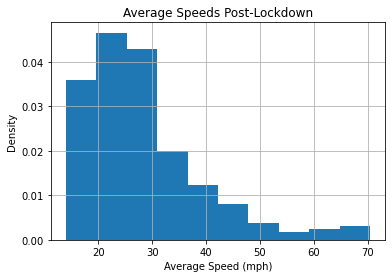

In [36]:
averages_post.hist(density = True)
plt.title("Average Speeds Post-Lockdown")
plt.xlabel("Average Speed (mph)")
plt.ylabel("Density")

<!-- END QUESTION -->

<!-- BEGIN QUESTION -->

### 2.a.iii. Sort census tracts by change in traffic speed from pre to post lockdown.

For each segment, compute the difference between the pre-lockdown average speed (March 1 - 13) and the post-lockdown average speed (March 14 - 31). **Plot a histogram of all differences.** Sanity check that the below histogram matches your observations of the histograms above, on your own.

<!--
BEGIN QUESTION
name: q2aiii
points: 2
manual: True
-->

Text(0, 0.5, 'Density')

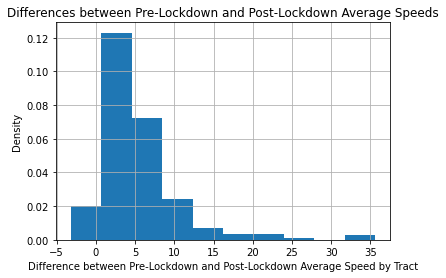

In [37]:
# The autograder expects differences to be a series object with index
# MOVEMENT_ID.
differences = averages_post - averages_pre
# plot the differences

differences.hist(density = True)
plt.title("Differences between Pre-Lockdown and Post-Lockdown Average Speeds")
plt.xlabel("Difference between Pre-Lockdown and Post-Lockdown Average Speed by Tract")
plt.ylabel("Density")

In [38]:
grader.check("q2aiii")

q2aiii results: All test cases passed!

<!-- END QUESTION -->

<!-- BEGIN QUESTION -->

### 2.a.iv. Quantify the impact of lockdown on average speeds.

1. **Plot the average speed by day, across all segments**. Be careful not to plot the average of census tract averages instead. Recall the definition of segments from Q1.
2. Is the change in speed smooth and gradually increasing? Or increasing sharply? Why? Use your real-world knowledge of announcements and measures during that time, in your explanation. You can use this list of bay area COVID-related dataes: https://abc7news.com/timeline-of-coronavirus-us-covid-19-bay-area-sf/6047519/

<!--
BEGIN QUESTION
name: q2aiv1
points: 1
manual: True
-->

Text(0, 0.5, 'Average Speed (mph)')

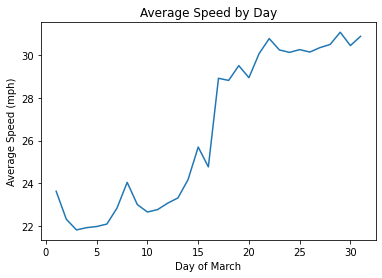

In [39]:
# Autograder expects this to be a series object containing the
# data for your line plot -- average speeds per day.
speeds_daily = speeds_to_tract.groupby("day").mean()["speed_mph_mean"]
speeds_daily.plot()
plt.title("Average Speed by Day")
plt.xlabel("Day of March")
plt.ylabel("Average Speed (mph)")

<!-- END QUESTION -->

<!-- BEGIN QUESTION -->

Write your written answer in the cell below

<!--
BEGIN QUESTION
name: q2aiv2
points: 1
manual: True
-->

The change in speed is not smooth or gradual, rather it is sudden, with a sharp increase between the 16th and 17th of March. I found this suprising because I thought the increase in speed would correlate with the start of the lockdown on the 14th, however, the increase occurs around 2 days later. However, I now see, from the article, that this is most likely due to the Shelter in Pace order that was announced on March 16th, 2020 for six Bay Area counties, which took effect at midnight, March 17th. This explains the dramatic increase in average speed between 16th and 17th, which is explained by the dramatic decrease in traffic.

<!-- END QUESTION -->

Ignore the empty cell below, just run the autograder to test the code above is correct.
<!--
BEGIN QUESTION
name: q2aiv3
points: 1
-->

In [40]:
grader.check("q2aiv3")

q2aiv3 results: All test cases passed!

<!-- BEGIN QUESTION -->

### 2.a.v. Quantify the impact of pre-lockdown average speed on change in speed.

1. Compute the correlation between change in speed and the *pre*-lockdown average speeds. Do we expect a positive or negative correlation, given our analysis above?
2. Compute the correlation between change in speed and the post-lockdown average speeds.
3. **How does the correlation in Q1 compare with the correlation in Q2?** You should expect a significant change in correlation value. What insight does this provide about traffic?

Written answers in the first cell, coding answerts in the following cell.

<!--
BEGIN QUESTION
name: q2av1
points: 2
manual: True
-->

The correlation increased quite a bit between Q1 and Q2, and we expect a positive correlation for both values based on our analysis. This is because since we are looking at the *changes* in speeds pre and post lockdown, we expect high values of post lockdown average speeds to be correlated with high values of differences; if the average speed dramatically increased, the difference between the pre and post-lockdown speeds would also increase. This explains the higher correlation coefficient for the relationship between change in speed and the post-lockdown average speeds (as compared to the relationship between change in speed and the pre-lockdown average speeds). In terms of traffic, this shows us that average speeds did increase.

<!-- END QUESTION -->


<!--
BEGIN QUESTION
name: q2av2
points: 2
-->

In [41]:
corr_pre_diff = averages_pre.corr(differences)
corr_post_diff = averages_post.corr(differences)
corr_pre_diff, corr_post_diff

(0.46330063805801847, 0.7926799984780658)

In [42]:
grader.check("q2av2")

q2av2 results: All test cases passed!

## 2.b. What traffic areas were impacted by lockdown?

<!-- BEGIN QUESTION -->

### 2.b.i. Visualize spatial heatmap of average traffic speed per census tract, pre-lockdown.

Visualize a spatial heatmap of the grouped average daily speeds per census tract, which you computed in previous parts. Use the geopandas [chloropleth maps](https://geopandas.org/docs/user_guide/mapping.html#choropleth-maps). **Write your observations, using your visualization, noting down at least 2 areas or patterns of interest**. These may be a local extrema, or a region that is strangely all similar.

**Hint**: Use [`to_crs`](https://geopandas.org/docs/reference/api/geopandas.GeoDataFrame.to_crs.html) and make sure the `epsg` is using the Pseudo-Mercator projection.

**Hint**: You can use `contextily` to superimpose your chloropleth map on a real geographic map.

**Hint** You can set a lower opacity for your chloropleth map, to see what's underneath, but be aware that if you plot with too low of an opacity, the map underneath will perturb your chloropleth and meddle with your conclusions.

Written answers in the first cell, coding answers in the second cell.

<!--
BEGIN QUESTION
name: q2bi1
points: 1
manual: True
-->

Overall average speeds within San Francisco are overall the lowest among the average speeds of census tracts within the bay area, signified by almost the entire city being purple. On the other hand, the surrounding cities generally have higher average speeds, as evidenced by the more greenish hue of these tracts. Further, the large northwestern census tract by Fairfax is interesting in that the entire area has a singular average speed. Another large tract is formed south of San Francisco and has a light green hue. Both of these large areas correspond to parks within the bay area.

<!-- END QUESTION -->

<!-- BEGIN QUESTION -->

<!--
BEGIN QUESTION
name: q2bi2
points: 4
manual: True
-->

Text(0.5, 1.0, 'Grouped Average Daily Speeds per Census Tract')

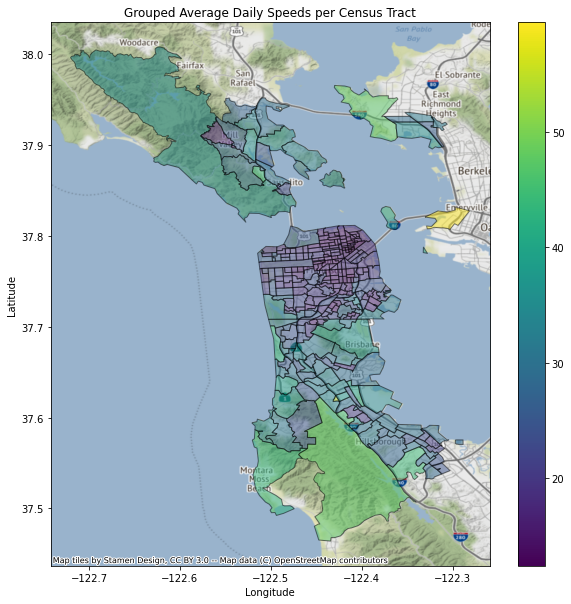

In [43]:
averages_pre_named.set_crs(crs = None, epsg = 3857, inplace = False, allow_override = False)
plot = averages_pre_named.plot(column = "speed_mph_mean", figsize=(10, 10), alpha=0.5, edgecolor='k', legend = True)
cx.add_basemap(plot, crs = averages_pre_named.crs.to_string())
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.title("Grouped Average Daily Speeds per Census Tract")

<!-- END QUESTION -->

<!-- BEGIN QUESTION -->

### 2.b.ii. Visualize change in average daily speeds pre vs. post lockdown.

Visualize a spatial heatmap of the census tract differences in average speeds, that we computed in a previous part. **Write your observations, using your visualization, noting down at least 2 areas or patterns of interest.** Some possible ideas for interesting notes: Which areas saw the most change in average speed? Which areas weren't affected? Why did some areas see *reduced* average speed?

First cell is for the written answers, second cell is for the coding answers.

<!--
BEGIN QUESTION
name: q2bii1
points: 1
manual: True
-->

The greatest difference between pre and post-lockdown average speeds is in two census tracts near Hillsborough (yellow colored). Further, speeds within San Francisco generally did not change much, as most of the city is purple hued. Near Emeryville, although it had the highest average speed in the bay area, this census tract experienced little to no difference pre and post lockdown. 

<!-- END QUESTION -->

<!-- BEGIN QUESTION -->

<!--
BEGIN QUESTION
name: q2bii2
points: 4
manual: True
-->

Text(0.5, 1.0, 'Census Tract Differences in Average Speeds')

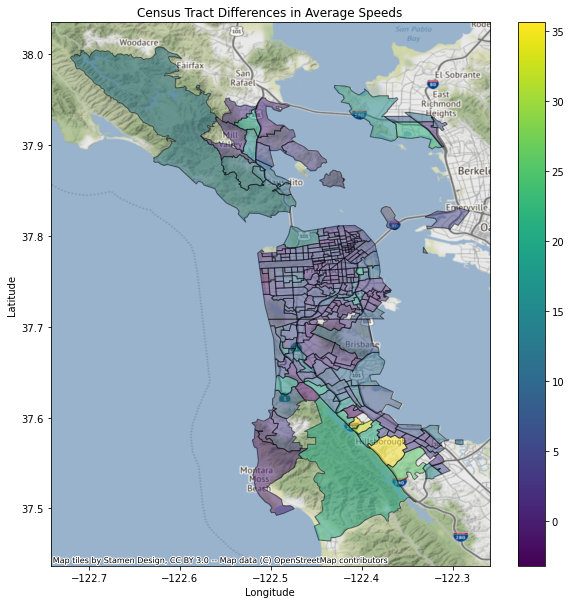

In [44]:
average_diffs = averages_pre_named[["DISPLAY_NAME", "geometry"]].set_crs(crs = None, epsg = 3857, inplace = False, allow_override = False)
average_diffs["differences"] = differences
plot2 = average_diffs.plot(column = "differences", figsize=(10, 10), alpha=0.5, edgecolor='k', legend = True)
cx.add_basemap(plot2, crs = averages_pre_named.crs.to_string())
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.title("Census Tract Differences in Average Speeds")

<!-- END QUESTION -->



# Step 3 - Open-Ended EDA: Understanding lockdown impact on travel times

Explore daily travel times from Hayes Valley to other destinations both before and throughout lockdown. Use the following questions as suggestions for what to explore, temporally and spatially:

- How did lockdown affect travel times? Are there any meaningful factors that determined how travel time would be impacted? How was travel time affected over time?
- Travel to which destinations were affected by lockdown? Are there surprisingly disproportionate amounts of impact in certain areas?

## 3.a. Load Datasets

In this step, we will load two datasets:

- Daily travel times from Hayes Valley to all other census tracts around San Francisco.
- Daily travel times from 300 Hayes St to Golden Gate Park in San Francisco.

For this specific set of data, we can ask several more questions; which questions you pursue are up to you, including any that you come up that are not on this list:

- Which routes from Hayes Valley had similar impact on travel time? Did they share any factors in common? Traveling through the same place -- e.g., a freway? Traveling in similar areas e.g., residential areas?
- Were clusters of routes impacted more severely than others over time? What determined the degree of impact?

In [45]:
PATH_TIMES = 'data/travel-times-daily-san-francisco-2020-3.csv'
times_to_tract = pd.read_csv(PATH_TIMES)
times_to_tract

,Origin Movement ID,Origin Display Name,Destination Movement ID,Destination Display Name,Date Range,Mean Travel Time (Seconds),Range - Lower Bound Travel Time (Seconds),Range - Upper Bound Travel Time (Seconds),day
0,1277,"300 Hayes Street, Civic Center, San Francisco",9,"500 Hyde Street, Tenderloin, San Francisco","3/1/2020 - 3/1/2020, Every day, Daily Average",322,211,489,1
1,1277,"300 Hayes Street, Civic Center, San Francisco",20,"900 Sutter Street, Lower Nob Hill, San Francisco","3/1/2020 - 3/1/2020, Every day, Daily Average",291,179,470,1
2,1277,"300 Hayes Street, Civic Center, San Francisco",21,"3400 Pierce Street, Marina District, San Franc...","3/1/2020 - 3/1/2020, Every day, Daily Average",635,438,920,1
3,1277,"300 Hayes Street, Civic Center, San Francisco",44,"1700 Egbert Avenue, Bayview, San Francisco","3/1/2020 - 3/1/2020, Every day, Daily Average",786,566,1090,1
4,1277,"300 Hayes Street, Civic Center, San Francisco",46,"500 Chester Street, West Oakland, Oakland","3/1/2020 - 3/1/2020, Every day, Daily Average",891,682,1162,1
...,...,...,...,...,...,...,...,...,...
10333,1277,"300 Hayes Street, Civic Center, San Francisco",2624,"1300 16th Avenue, Inner Sunset, San Francisco","3/31/2020 - 3/31/2020, Every day, Daily Average",502,411,611,31
10334,1277,"300 Hayes Street, Civic Center, San Francisco",2643,"1300 Egbert Avenue, Bayview, San Francisco","3/31/2020 - 3/31/2020, Every day, Daily Average",571,475,685,31
10335,1277,"300 Hayes Street, Civic Center, San Francisco",2673,"100 Rutledge Street, Bernal Heights, San Franc...","3/31/2020 - 3/31/2020, Every day, Daily Average",367,265,507,31
10336,1277,"300 Hayes Street, Civic Center, San Francisco",2694,"1900 Buchanan Street, Western Addition, San Fr...","3/31/2020 - 3/31/2020, Every day, Daily Average",222,167,294,31


Text(0, 0.5, 'Mean Travel Time (Seconds)')

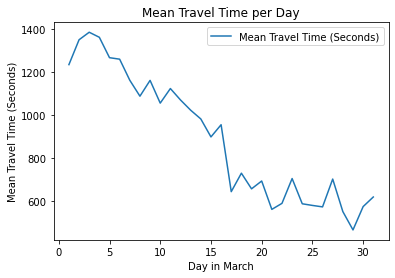

In [46]:
means_per_time = times_to_tract.groupby("day").mean()
means_per_time[["Mean Travel Time (Seconds)"]].plot()
plt.title("Mean Travel Time per Day")
plt.xlabel("Day in March")
plt.ylabel("Mean Travel Time (Seconds)")

In [47]:
pre_mean = times_to_tract[["Destination Movement ID", "Mean Travel Time (Seconds)", "day"]][(times_to_tract["day"] < 14)].groupby("Destination Movement ID").mean()
post_mean = times_to_tract[["Destination Movement ID", "Mean Travel Time (Seconds)", "day"]][times_to_tract["day"] > 13].groupby("Destination Movement ID").mean()
pre_mean

,Mean Travel Time (Seconds),day
Destination Movement ID,,
2,1977.000000,7.0
9,343.615385,7.0
20,319.461538,7.0
21,622.153846,7.0
30,1338.000000,8.0
...,...,...
2694,349.923077,7.0
2695,1134.615385,7.0
2697,1887.000000,7.0


In [48]:
post_mean

,Mean Travel Time (Seconds),day
Destination Movement ID,,
9,253.777778,22.500000
20,228.888889,22.500000
21,472.200000,21.266667
44,643.083333,22.166667
46,876.444444,22.500000
...,...,...
2673,342.444444,22.500000
2694,254.277778,22.500000
2695,1059.500000,19.000000


Text(0, 0.5, 'Density')

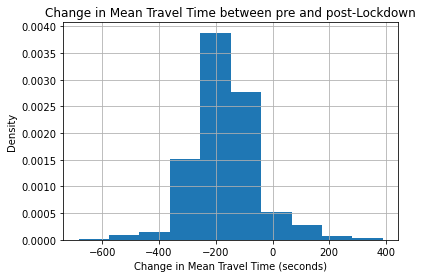

In [49]:
hayes_diff = post_mean.join(pre_mean, rsuffix = "pre", lsuffix = "post")
hayes_diff = hayes_diff.dropna()
mean_diffs = hayes_diff["Mean Travel Time (Seconds)post"] - hayes_diff["Mean Travel Time (Seconds)pre"]
mean_diffs.hist(density = True)
plt.title("Change in Mean Travel Time between pre and post-Lockdown")
plt.xlabel("Change in Mean Travel Time (seconds)")
plt.ylabel("Density")

Text(198.0047479513424, 0.5, 'Latitude')

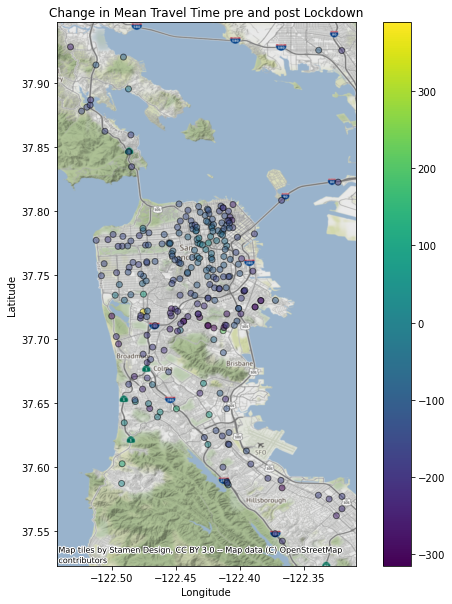

In [50]:
hayes_diff["diff"] = mean_diffs
id_geo = speeds_to_tract[["MOVEMENT_ID", "geometry", "Latitude", "Longitude"]].groupby("MOVEMENT_ID").first()
mean_geo = hayes_diff.join(id_geo).dropna()
geo_mean = gpd.GeoDataFrame(mean_geo, geometry=gpd.points_from_xy(mean_geo.Longitude, mean_geo.Latitude)).set_crs(epsg = 3857)
plot3 = geo_mean.plot(column = "diff", figsize = (10, 10), alpha = 0.5, edgecolor = "k", legend = True)
cx.add_basemap(plot3, crs = averages_pre_named.crs.to_string())
plt.title("Change in Mean Travel Time pre and post Lockdown")
plt.xlabel("Longitude")
plt.ylabel("Latitude")

It appears that the Lockdown had a negative impact on mean travel time, meaning that people generally got to their destinations from 300 Hayes faster after lockdown. Interstingly, we see outliers where it took longer to get to their destination after lockdown. We might want to look into what factors determines the magnitude of change.

In [51]:
pre_max = times_to_tract[(times_to_tract["day"] < 14)].groupby("Destination Movement ID").max()
pre_min = times_to_tract[(times_to_tract["day"] < 14)].groupby("Destination Movement ID").min()
post_max = times_to_tract[times_to_tract["day"] > 13].groupby("Destination Movement ID").max()
post_min = times_to_tract[times_to_tract["day"] > 13].groupby("Destination Movement ID").min()

In [52]:
pre_max

,Origin Movement ID,Origin Display Name,Destination Display Name,Date Range,Mean Travel Time (Seconds),Range - Lower Bound Travel Time (Seconds),Range - Upper Bound Travel Time (Seconds),day
Destination Movement ID,,,,,,,,
2,1277,"300 Hayes Street, Civic Center, San Francisco","400 Northumberland Avenue, Redwood Oaks, Redwo...","3/7/2020 - 3/7/2020, Every day, Daily Average",1977,1706,2289,7
9,1277,"300 Hayes Street, Civic Center, San Francisco","500 Hyde Street, Tenderloin, San Francisco","3/9/2020 - 3/9/2020, Every day, Daily Average",376,251,590,13
20,1277,"300 Hayes Street, Civic Center, San Francisco","900 Sutter Street, Lower Nob Hill, San Francisco","3/9/2020 - 3/9/2020, Every day, Daily Average",359,220,595,13
21,1277,"300 Hayes Street, Civic Center, San Francisco","3400 Pierce Street, Marina District, San Franc...","3/9/2020 - 3/9/2020, Every day, Daily Average",723,513,1017,13
30,1277,"300 Hayes Street, Civic Center, San Francisco","2200 Central Avenue, Alameda","3/8/2020 - 3/8/2020, Every day, Daily Average",1338,1160,1542,8
...,...,...,...,...,...,...,...,...
2694,1277,"300 Hayes Street, Civic Center, San Francisco","1900 Buchanan Street, Western Addition, San Fr...","3/9/2020 - 3/9/2020, Every day, Daily Average",388,239,639,13
2695,1277,"300 Hayes Street, Civic Center, San Francisco","2200 Rivera Street, Sunset District, San Franc...","3/9/2020 - 3/9/2020, Every day, Daily Average",1296,999,1690,13
2697,1277,"300 Hayes Street, Civic Center, San Francisco","200 F Street, Centennial, Redwood City","3/7/2020 - 3/7/2020, Every day, Daily Average",1887,1670,2131,7


In [53]:
pre_min

,Origin Movement ID,Origin Display Name,Destination Display Name,Date Range,Mean Travel Time (Seconds),Range - Lower Bound Travel Time (Seconds),Range - Upper Bound Travel Time (Seconds),day
Destination Movement ID,,,,,,,,
2,1277,"300 Hayes Street, Civic Center, San Francisco","400 Northumberland Avenue, Redwood Oaks, Redwo...","3/7/2020 - 3/7/2020, Every day, Daily Average",1977,1706,2289,7
9,1277,"300 Hayes Street, Civic Center, San Francisco","500 Hyde Street, Tenderloin, San Francisco","3/1/2020 - 3/1/2020, Every day, Daily Average",284,194,414,1
20,1277,"300 Hayes Street, Civic Center, San Francisco","900 Sutter Street, Lower Nob Hill, San Francisco","3/1/2020 - 3/1/2020, Every day, Daily Average",254,164,391,1
21,1277,"300 Hayes Street, Civic Center, San Francisco","3400 Pierce Street, Marina District, San Franc...","3/1/2020 - 3/1/2020, Every day, Daily Average",552,434,667,1
30,1277,"300 Hayes Street, Civic Center, San Francisco","2200 Central Avenue, Alameda","3/8/2020 - 3/8/2020, Every day, Daily Average",1338,1160,1542,8
...,...,...,...,...,...,...,...,...
2694,1277,"300 Hayes Street, Civic Center, San Francisco","1900 Buchanan Street, Western Addition, San Fr...","3/1/2020 - 3/1/2020, Every day, Daily Average",292,192,442,1
2695,1277,"300 Hayes Street, Civic Center, San Francisco","2200 Rivera Street, Sunset District, San Franc...","3/1/2020 - 3/1/2020, Every day, Daily Average",963,772,1030,1
2697,1277,"300 Hayes Street, Civic Center, San Francisco","200 F Street, Centennial, Redwood City","3/7/2020 - 3/7/2020, Every day, Daily Average",1887,1670,2131,7


In [54]:
post_max

,Origin Movement ID,Origin Display Name,Destination Display Name,Date Range,Mean Travel Time (Seconds),Range - Lower Bound Travel Time (Seconds),Range - Upper Bound Travel Time (Seconds),day
Destination Movement ID,,,,,,,,
9,1277,"300 Hayes Street, Civic Center, San Francisco","500 Hyde Street, Tenderloin, San Francisco","3/31/2020 - 3/31/2020, Every day, Daily Average",331,201,592,31
20,1277,"300 Hayes Street, Civic Center, San Francisco","900 Sutter Street, Lower Nob Hill, San Francisco","3/31/2020 - 3/31/2020, Every day, Daily Average",296,184,486,31
21,1277,"300 Hayes Street, Civic Center, San Francisco","3400 Pierce Street, Marina District, San Franc...","3/30/2020 - 3/30/2020, Every day, Daily Average",554,458,712,30
44,1277,"300 Hayes Street, Civic Center, San Francisco","1700 Egbert Avenue, Bayview, San Francisco","3/31/2020 - 3/31/2020, Every day, Daily Average",810,570,2740,31
46,1277,"300 Hayes Street, Civic Center, San Francisco","500 Chester Street, West Oakland, Oakland","3/31/2020 - 3/31/2020, Every day, Daily Average",1546,803,3140,31
...,...,...,...,...,...,...,...,...
2673,1277,"300 Hayes Street, Civic Center, San Francisco","100 Rutledge Street, Bernal Heights, San Franc...","3/31/2020 - 3/31/2020, Every day, Daily Average",432,304,613,31
2694,1277,"300 Hayes Street, Civic Center, San Francisco","1900 Buchanan Street, Western Addition, San Fr...","3/31/2020 - 3/31/2020, Every day, Daily Average",360,216,597,31
2695,1277,"300 Hayes Street, Civic Center, San Francisco","2200 Rivera Street, Sunset District, San Franc...","3/31/2020 - 3/31/2020, Every day, Daily Average",1188,935,1551,31


In [55]:
post_min

,Origin Movement ID,Origin Display Name,Destination Display Name,Date Range,Mean Travel Time (Seconds),Range - Lower Bound Travel Time (Seconds),Range - Upper Bound Travel Time (Seconds),day
Destination Movement ID,,,,,,,,
9,1277,"300 Hayes Street, Civic Center, San Francisco","500 Hyde Street, Tenderloin, San Francisco","3/14/2020 - 3/14/2020, Every day, Daily Average",212,151,296,14
20,1277,"300 Hayes Street, Civic Center, San Francisco","900 Sutter Street, Lower Nob Hill, San Francisco","3/14/2020 - 3/14/2020, Every day, Daily Average",189,111,252,14
21,1277,"300 Hayes Street, Civic Center, San Francisco","3400 Pierce Street, Marina District, San Franc...","3/14/2020 - 3/14/2020, Every day, Daily Average",402,354,455,14
44,1277,"300 Hayes Street, Civic Center, San Francisco","1700 Egbert Avenue, Bayview, San Francisco","3/14/2020 - 3/14/2020, Every day, Daily Average",505,236,580,14
46,1277,"300 Hayes Street, Civic Center, San Francisco","500 Chester Street, West Oakland, Oakland","3/14/2020 - 3/14/2020, Every day, Daily Average",719,642,785,14
...,...,...,...,...,...,...,...,...
2673,1277,"300 Hayes Street, Civic Center, San Francisco","100 Rutledge Street, Bernal Heights, San Franc...","3/14/2020 - 3/14/2020, Every day, Daily Average",310,241,395,14
2694,1277,"300 Hayes Street, Civic Center, San Francisco","1900 Buchanan Street, Western Addition, San Fr...","3/14/2020 - 3/14/2020, Every day, Daily Average",194,146,248,14
2695,1277,"300 Hayes Street, Civic Center, San Francisco","2200 Rivera Street, Sunset District, San Franc...","3/14/2020 - 3/14/2020, Every day, Daily Average",917,778,1080,14


In [56]:
pre_range = pre_max["Range - Upper Bound Travel Time (Seconds)"] - pre_min["Range - Lower Bound Travel Time (Seconds)"]
pre_max["range"] = pre_range
pre_max

,Origin Movement ID,Origin Display Name,Destination Display Name,Date Range,Mean Travel Time (Seconds),Range - Lower Bound Travel Time (Seconds),Range - Upper Bound Travel Time (Seconds),day,range
Destination Movement ID,,,,,,,,,
2,1277,"300 Hayes Street, Civic Center, San Francisco","400 Northumberland Avenue, Redwood Oaks, Redwo...","3/7/2020 - 3/7/2020, Every day, Daily Average",1977,1706,2289,7,583
9,1277,"300 Hayes Street, Civic Center, San Francisco","500 Hyde Street, Tenderloin, San Francisco","3/9/2020 - 3/9/2020, Every day, Daily Average",376,251,590,13,396
20,1277,"300 Hayes Street, Civic Center, San Francisco","900 Sutter Street, Lower Nob Hill, San Francisco","3/9/2020 - 3/9/2020, Every day, Daily Average",359,220,595,13,431
21,1277,"300 Hayes Street, Civic Center, San Francisco","3400 Pierce Street, Marina District, San Franc...","3/9/2020 - 3/9/2020, Every day, Daily Average",723,513,1017,13,583
30,1277,"300 Hayes Street, Civic Center, San Francisco","2200 Central Avenue, Alameda","3/8/2020 - 3/8/2020, Every day, Daily Average",1338,1160,1542,8,382
...,...,...,...,...,...,...,...,...,...
2694,1277,"300 Hayes Street, Civic Center, San Francisco","1900 Buchanan Street, Western Addition, San Fr...","3/9/2020 - 3/9/2020, Every day, Daily Average",388,239,639,13,447
2695,1277,"300 Hayes Street, Civic Center, San Francisco","2200 Rivera Street, Sunset District, San Franc...","3/9/2020 - 3/9/2020, Every day, Daily Average",1296,999,1690,13,918
2697,1277,"300 Hayes Street, Civic Center, San Francisco","200 F Street, Centennial, Redwood City","3/7/2020 - 3/7/2020, Every day, Daily Average",1887,1670,2131,7,461


In [57]:
post_range = post_max["Range - Upper Bound Travel Time (Seconds)"] - post_min["Range - Lower Bound Travel Time (Seconds)"]
post_max["range"] = post_range
post_max

,Origin Movement ID,Origin Display Name,Destination Display Name,Date Range,Mean Travel Time (Seconds),Range - Lower Bound Travel Time (Seconds),Range - Upper Bound Travel Time (Seconds),day,range
Destination Movement ID,,,,,,,,,
9,1277,"300 Hayes Street, Civic Center, San Francisco","500 Hyde Street, Tenderloin, San Francisco","3/31/2020 - 3/31/2020, Every day, Daily Average",331,201,592,31,441
20,1277,"300 Hayes Street, Civic Center, San Francisco","900 Sutter Street, Lower Nob Hill, San Francisco","3/31/2020 - 3/31/2020, Every day, Daily Average",296,184,486,31,375
21,1277,"300 Hayes Street, Civic Center, San Francisco","3400 Pierce Street, Marina District, San Franc...","3/30/2020 - 3/30/2020, Every day, Daily Average",554,458,712,30,358
44,1277,"300 Hayes Street, Civic Center, San Francisco","1700 Egbert Avenue, Bayview, San Francisco","3/31/2020 - 3/31/2020, Every day, Daily Average",810,570,2740,31,2504
46,1277,"300 Hayes Street, Civic Center, San Francisco","500 Chester Street, West Oakland, Oakland","3/31/2020 - 3/31/2020, Every day, Daily Average",1546,803,3140,31,2498
...,...,...,...,...,...,...,...,...,...
2673,1277,"300 Hayes Street, Civic Center, San Francisco","100 Rutledge Street, Bernal Heights, San Franc...","3/31/2020 - 3/31/2020, Every day, Daily Average",432,304,613,31,372
2694,1277,"300 Hayes Street, Civic Center, San Francisco","1900 Buchanan Street, Western Addition, San Fr...","3/31/2020 - 3/31/2020, Every day, Daily Average",360,216,597,31,451
2695,1277,"300 Hayes Street, Civic Center, San Francisco","2200 Rivera Street, Sunset District, San Franc...","3/31/2020 - 3/31/2020, Every day, Daily Average",1188,935,1551,31,773


In [58]:
range_diffs = post_max[["range"]].join(pre_max[["range"]], rsuffix = "pre", lsuffix = "post")
range_diffs.dropna()

,rangepost,rangepre
Destination Movement ID,,
9,441,396.0
20,375,431.0
21,358,583.0
44,2504,1170.0
46,2498,1104.0
...,...,...
2673,372,488.0
2694,451,447.0
2695,773,918.0


Text(0, 0.5, 'Density')

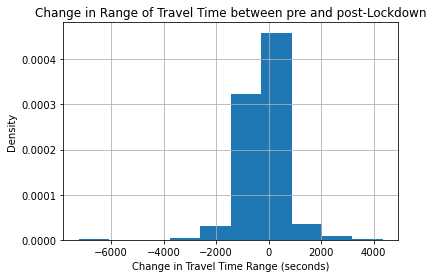

In [59]:
range_diff = range_diffs["rangepost"] - range_diffs["rangepre"]
range_diff.hist(density = True)
plt.title("Change in Range of Travel Time between pre and post-Lockdown")
plt.xlabel("Change in Travel Time Range (seconds)")
plt.ylabel("Density")

In [60]:
range_diffs["diff"] = range_diff
range_diffs

,rangepost,rangepre,diff
Destination Movement ID,,,
9,441,396.0,45.0
20,375,431.0,-56.0
21,358,583.0,-225.0
44,2504,1170.0,1334.0
46,2498,1104.0,1394.0
...,...,...,...
2673,372,488.0,-116.0
2694,451,447.0,4.0
2695,773,918.0,-145.0


Text(198.0047479513424, 0.5, 'Latitude')

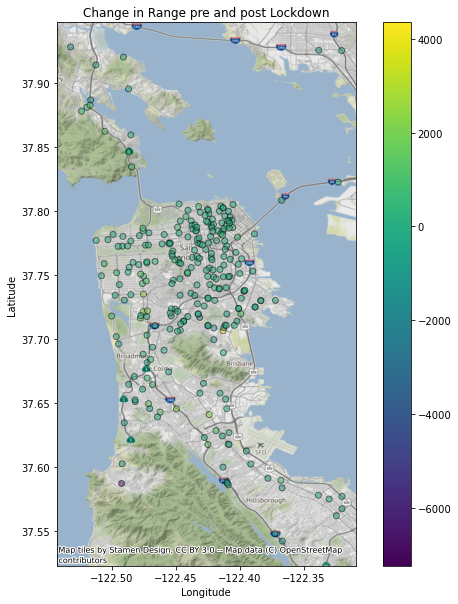

In [61]:
id_geo = speeds_to_tract[["MOVEMENT_ID", "geometry", "Latitude", "Longitude"]].groupby("MOVEMENT_ID").first()
range_geo = range_diffs.join(id_geo).dropna()
geo_range = gpd.GeoDataFrame(range_geo, geometry=gpd.points_from_xy(range_geo.Longitude, range_geo.Latitude)).set_crs(epsg = 3857)
plot4 = geo_range.plot(column = "diff", figsize = (10, 10), alpha = 0.5, edgecolor = "k", legend = True)
cx.add_basemap(plot4, crs = averages_pre_named.crs.to_string())
plt.title("Change in Range pre and post Lockdown")
plt.xlabel("Longitude")
plt.ylabel("Latitude")

---

To double-check your work, the cell below will rerun all of the autograder tests.

In [62]:
grader.check_all()

q1a results: All test cases passed!

q1bi results: All test cases passed!

q1bii results: All test cases passed!

q1biii results: All test cases passed!

q1biv results: All test cases passed!

q1bv3 results: All test cases passed!

q1ci results: All test cases passed!

q1cii results: All test cases passed!

q1ciii results: All test cases passed!

q1civ3 results: All test cases passed!

q2ai2 results: All test cases passed!

q2ai3 results: All test cases passed!

q2ai4 results: All test cases passed!

q2aii2 results: All test cases passed!

q2aiii results: All test cases passed!

q2aiv3 results: All test cases passed!

q2av2 results: All test cases passed!

## Submission

Make sure you have run all cells in your notebook in order before running the cell below, so that all images/graphs appear in the output. The cell below will generate a zip file for you to submit. **Please save before exporting!**

In [63]:
# Save your notebook first, then run this cell to export your submission.
grader.export()